In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
from datetime import date
from dateutil.relativedelta import relativedelta
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.stats import boxcox
from pylab import rcParams
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import or assign API key
api_key = "58394c9866a5e8ff6f27cbd23af8e6f7"

# Define the FRED API endpoint
base_url = 'https://api.stlouisfed.org/fred/'

'''
Get observation data from the FRED API
'''

# Assign endpoint
obs_endpoint = 'series/observations'

# Assign parameters
series_id = 'T10YIE'   #FEDFUNDS
start_date = '1999-01-01'
end_date = '2024-01-31'
#ts_frequency = 'm'
#ts_units = 'pc1'

obs_params = {
    'series_id': series_id,
    'api_key': api_key,
    'file_type': 'json',
    'observation_start': start_date,
    'observation_end': end_date,
    # 'frequency': ts_frequency
    # 'units': ts_units
}

# Make request to FRED API
response = requests.get(base_url + obs_endpoint, params=obs_params)

# Format data
if response.status_code == 200:
    res_data = response.json()
    obs_data = pd.DataFrame(res_data['observations'])
    obs_data['date'] = pd.to_datetime(obs_data['date'])
    obs_data['Year']=obs_data['date'].dt.year
    obs_data['Month']=obs_data['date'].dt.month
    obs_data.set_index('date', inplace=True)
    obs_data['Inflation'] = obs_data['value']#.astype(float)
    obs_data = obs_data.drop(columns=["realtime_start", "realtime_end","value"])

else:
    print('Failed to retrieve data. Status code:', response.status_code)

# DATA WRANGLING TO REMOVE "." FROM INFLATION DATASET

In [4]:
obs_data.Inflation = pd.to_numeric(obs_data['Inflation'], errors='coerce')
obs_data.head(30),obs_data.shape,obs_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5500 entries, 2003-01-02 to 2024-01-31
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       5500 non-null   int32  
 1   Month      5500 non-null   int32  
 2   Inflation  5275 non-null   float64
dtypes: float64(1), int32(2)
memory usage: 128.9 KB


(            Year  Month  Inflation
 date                              
 2003-01-02  2003      1       1.64
 2003-01-03  2003      1       1.62
 2003-01-06  2003      1       1.63
 2003-01-07  2003      1       1.62
 2003-01-08  2003      1       1.71
 2003-01-09  2003      1       1.78
 2003-01-10  2003      1       1.75
 2003-01-13  2003      1       1.77
 2003-01-14  2003      1       1.76
 2003-01-15  2003      1       1.80
 2003-01-16  2003      1       1.79
 2003-01-17  2003      1       1.80
 2003-01-20  2003      1        NaN
 2003-01-21  2003      1       1.78
 2003-01-22  2003      1       1.72
 2003-01-23  2003      1       1.78
 2003-01-24  2003      1       1.80
 2003-01-27  2003      1       1.82
 2003-01-28  2003      1       1.81
 2003-01-29  2003      1       1.85
 2003-01-30  2003      1       1.80
 2003-01-31  2003      1       1.81
 2003-02-03  2003      2       1.81
 2003-02-04  2003      2       1.84
 2003-02-05  2003      2       1.90
 2003-02-06  2003      2    

In [5]:
obs_data['Inflation'] = obs_data['Inflation'].replace(np.NaN,0)
obs_data = obs_data[obs_data['Inflation'] != 0.00]
obs_data.head(30),obs_data.shape

(            Year  Month  Inflation
 date                              
 2003-01-02  2003      1       1.64
 2003-01-03  2003      1       1.62
 2003-01-06  2003      1       1.63
 2003-01-07  2003      1       1.62
 2003-01-08  2003      1       1.71
 2003-01-09  2003      1       1.78
 2003-01-10  2003      1       1.75
 2003-01-13  2003      1       1.77
 2003-01-14  2003      1       1.76
 2003-01-15  2003      1       1.80
 2003-01-16  2003      1       1.79
 2003-01-17  2003      1       1.80
 2003-01-21  2003      1       1.78
 2003-01-22  2003      1       1.72
 2003-01-23  2003      1       1.78
 2003-01-24  2003      1       1.80
 2003-01-27  2003      1       1.82
 2003-01-28  2003      1       1.81
 2003-01-29  2003      1       1.85
 2003-01-30  2003      1       1.80
 2003-01-31  2003      1       1.81
 2003-02-03  2003      2       1.81
 2003-02-04  2003      2       1.84
 2003-02-05  2003      2       1.90
 2003-02-06  2003      2       1.88
 2003-02-07  2003      2    

In [6]:
df = obs_data.groupby(['Year', 'Month'])['Inflation'].mean().reset_index()
df['date'] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=1))

In [7]:
df =df[['date','Inflation']].set_index('date')

In [8]:
df.sort_values(by='date',inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2003-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflation  253 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


In [10]:
#df.date= pd.to_datetime(df.date)

In [11]:
#df.set_index('date',inplace=True)
df.tail()

,Inflation
date,
2023-09-01,2.342000
2023-10-01,2.386190
2023-11-01,2.304286
2023-12-01,2.184500
2024-01-01,2.266190


In [12]:
df.head()

,Inflation
date,
2003-01-01,1.754286
2003-02-01,1.912632
2003-03-01,1.862857
2003-04-01,1.774762
2003-05-01,1.660952


# **HISTOGRAM**

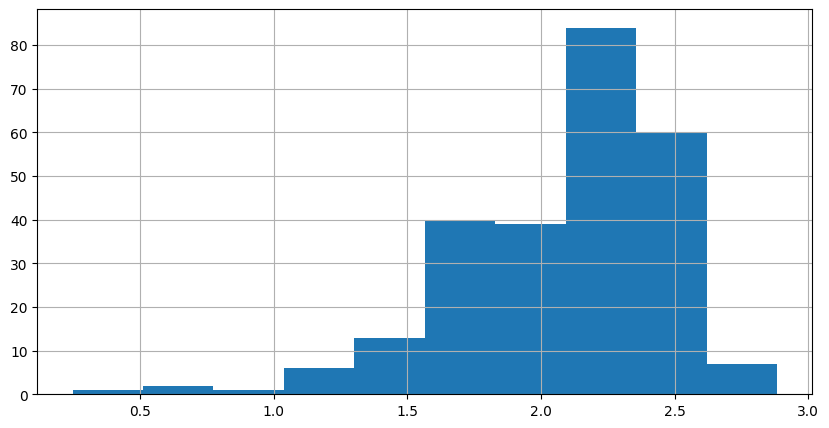

In [13]:
fig = df.Inflation.hist(figsize = (10,5))

# **Box Plot**

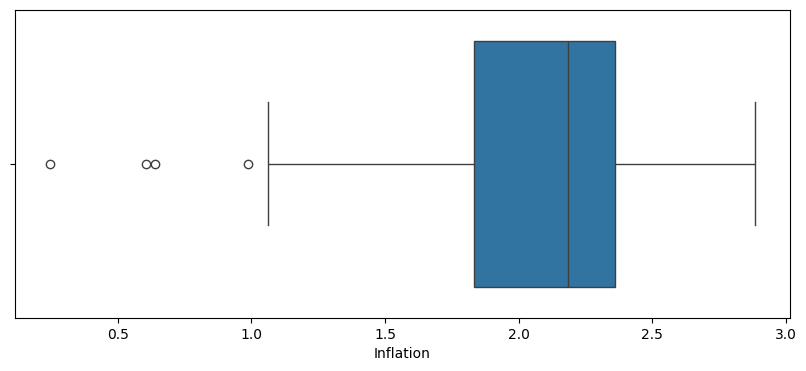

In [14]:
fig = plt.subplots(figsize=(10, 4))
ax = sns.boxplot(x=df.Inflation,whis=1.5)

# **Time Series Decomposition**

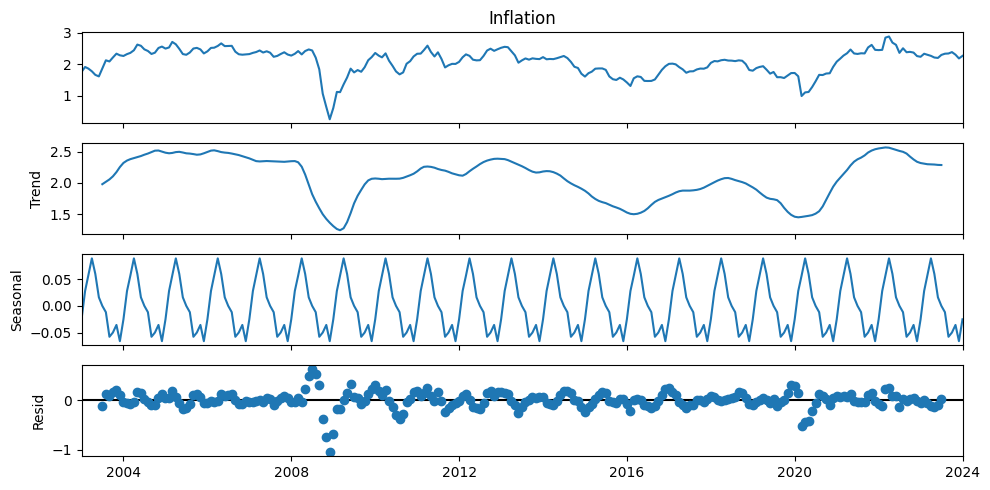

In [15]:
rcParams['figure.figsize'] = 10,5
decomposition = sm.tsa.seasonal_decompose(df.Inflation, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

In [16]:
#Transform original data with log
df_log_scaled = np.log(df)

In [17]:
#subtract the moving average from original data
ma = df.rolling(window=12).mean()
df_minus_ma = df - ma
df_minus_ma.dropna(inplace=True)

In [18]:
#subtract the moving average from log scaled data
ma01 = df_log_scaled.rolling(window=12).mean()
df_log_scaled_minus_ma = df - ma01
df_log_scaled_minus_ma.dropna(inplace=True)

In [19]:
dfCox = df.copy()

In [20]:
#Boxcox Transformation
dfCox['Boxcox'], lam = boxcox(dfCox['Inflation'])
dfCox["Boxcox_diff"] = dfCox["Boxcox"].diff()
dfCox.drop(['Inflation', 'Boxcox'], inplace=True, axis=1)
dfCox.dropna(inplace=True)


In [21]:
dfCox.head()

,Boxcox_diff
date,
2003-02-01,0.388475
2003-03-01,-0.127477
2003-04-01,-0.213544
2003-05-01,-0.253532
2003-06-01,-0.100709


# **Create A Function To Test Stationality For Different Transformation**

In [22]:
def test_stationarity(data):
  data.dropna(inplace=True)
  rolmean = data.rolling(window=12).mean()
  rolstd = data.rolling(window=12).std()

  orig = plt.plot(data,label="Original")
  mean = plt.plot(rolmean,label="Rolling mean")
  std = plt.plot(rolstd,label="Rolling std")
  plt.legend()

  dftest = adfuller(data)
  dfoutput = pd.Series(dftest[0:4],index=["The test statistics","Mackinnon's approximate p-value","#usedLags","NOBS"])
  print(dfoutput)


  #ACF and PCF for differenced data log scaled - MA
  acf_lag_df_data = acf(data,nlags=70)
  pacf_lag_df_data = pacf(data,nlags=70)

  fig,ax = plt.subplots(1,2,figsize=(15,5))

  plot_acf(acf_lag_df_data,ax=ax[0])
  plot_pacf(pacf_lag_df_data,ax=ax[1])
  plt.show()

  stepwise_fit = auto_arima(data, trace=True,suppress_warnings=True)


The test statistics                 -5.282089
Mackinnon's approximate p-value      0.000006
#usedLags                            1.000000
NOBS                               240.000000
dtype: float64


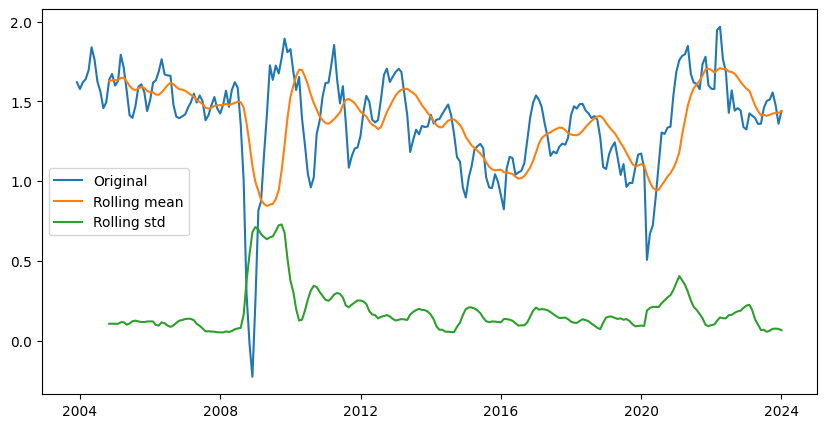

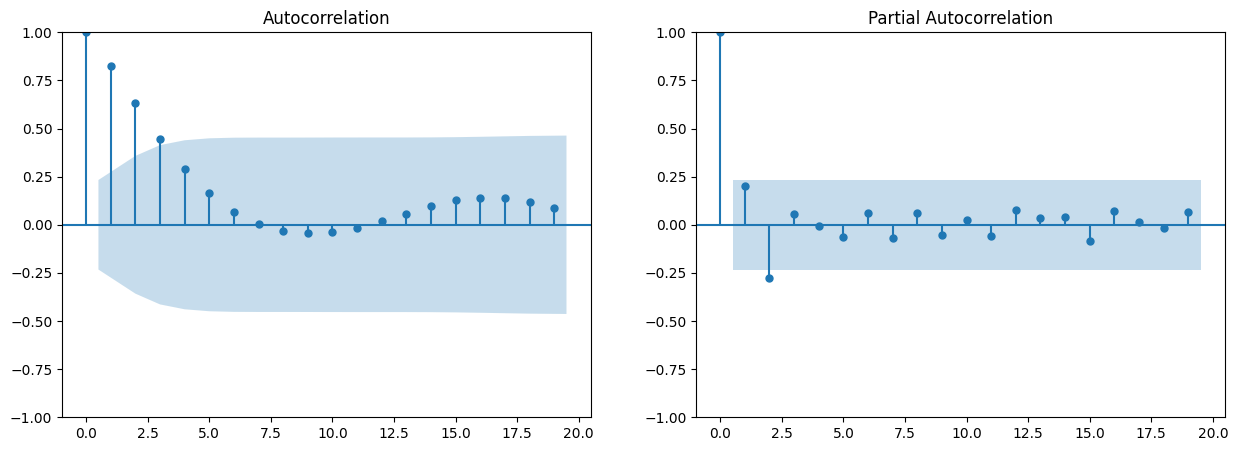

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-336.106, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=116.578, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-293.633, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-117.768, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=857.203, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-334.627, Time=0.68 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-337.868, Time=0.92 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-327.685, Time=1.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-338.953, Time=0.86 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-337.967, Time=0.49 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-336.001, Time=2.50 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 8.511 seconds


In [23]:
test_stationarity(df_log_scaled_minus_ma)

# Build Model To Test the AR, I and MA Parameters

In [24]:
# Split train and test
train_data = df.iloc[:-12]
print('Train size: ', len(train_data))
test_data = df.iloc[-12:]
print('Test size: ',len(test_data))

Train size:  241
Test size:  12


In [25]:
my_order = (2,0,0)
model=ARIMA(train_data,order=my_order)
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Inflation   No. Observations:                  241
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 155.341
Date:                Mon, 06 May 2024   AIC                           -302.682
Time:                        08:11:36   BIC                           -288.742
Sample:                    01-01-2003   HQIC                          -297.066
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0665      0.109     18.978      0.000       1.853       2.280
ar.L1          1.3157      0.036     36.055      0.000       1.244       1.387
ar.L2         -0.3988      0.038    -10.395      0.000      -0.474      -0.324
sigma2         0.0160      0.001     18.413      0.000       0.014       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               260.87
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.91
Prob(H) (two-sided):                  0.19   Kurtosis:                         7.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0, 0.5, 'Inflation')

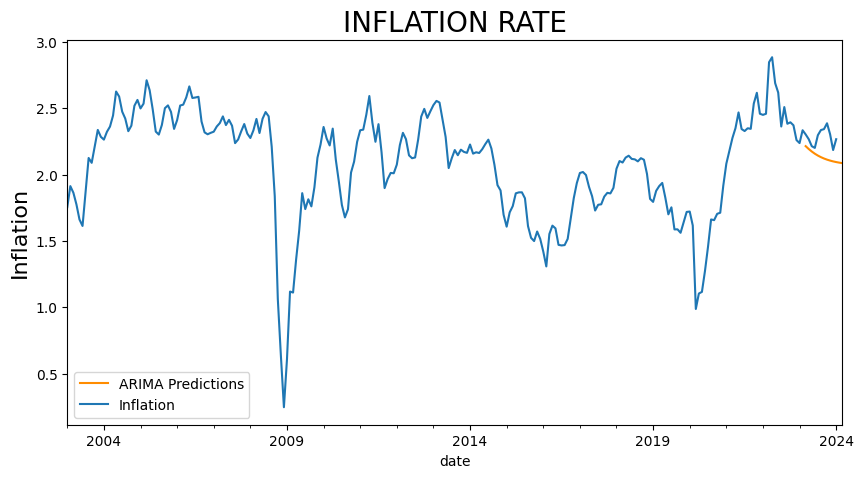

In [26]:
start=len(train_data)
end=len(train_data)+len(test_data)
pred=model.predict(start=start,end=end,type='levels').rename('ARIMA Predictions')
test_date = pd.date_range('2023-03-01', '2024-03-01', freq='MS')
predictions =  pd.DataFrame(pred).set_index(test_date)
Test_df =  pd.DataFrame(test_data)
residuals = test_data['Inflation'] - predictions['ARIMA Predictions']
#print(residuals)
predictions.plot(legend=True,color='darkorange')
df['Inflation'].plot(legend=True)
plt.title('INFLATION RATE', fontsize=20)
plt.ylabel('Inflation', fontsize=16)

Text(0, 0.5, 'Error')

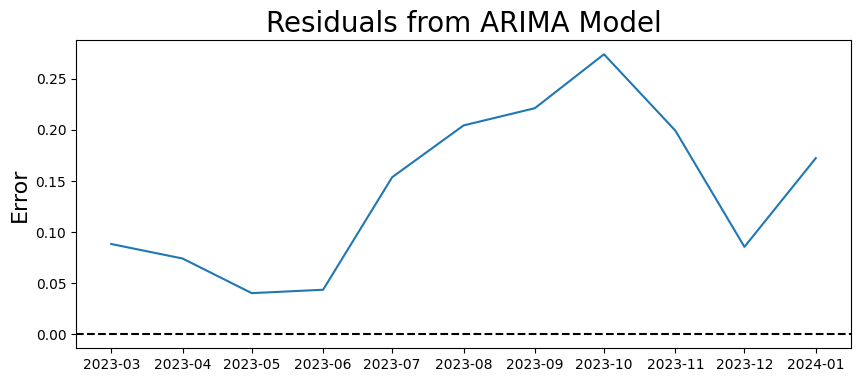

In [27]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [28]:
print('Mean Absolute Percent Error(%):', round(np.mean(abs(residuals/test_data['Inflation']*100)),4))

Mean Absolute Percent Error(%): 6.1309


In [29]:
print('Root Mean Squared Error(%):', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error(%): 0.16036573447083707


# Using the Rolling Forecast Origin

In [30]:
rolling_predictions = test_data.copy()
pred_list = []
for train_end in test_data.index:
  train_data = df[:train_end-timedelta(days=1)]
  model = ARIMA(train_data, order=my_order)
  model_fit = model.fit()
  pred = model_fit.forecast()
  pred_list.append(pred.values)
print(pred)
prediction = pd.DataFrame(pred_list)

2024-01-01    2.127565
Freq: MS, dtype: float64


In [31]:
test_date = pd.date_range('2023-04-01', '2024-03-01', freq='MS')

In [32]:
col2 = ['pred_var']
prediction.columns = col2
prediction.set_index(test_date,inplace=True)

In [33]:
prediction

,pred_var
2023-04-01,2.213859
2023-05-01,2.350576
2023-06-01,2.270435
2023-07-01,2.236039
2023-08-01,2.180611
2023-09-01,2.184410
2023-10-01,2.316307
2023-11-01,2.329212
2023-12-01,2.322828
2024-01-01,2.378598


In [34]:
rolling_residuals = test_data['Inflation'] - prediction['pred_var']

Text(0, 0.5, 'Error')

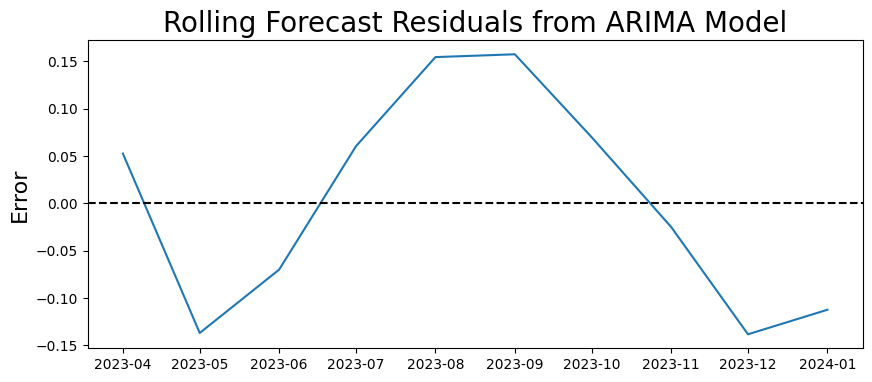

In [35]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [36]:
start_date = datetime(2023,2,1)
end_date = datetime(2024,1,1)

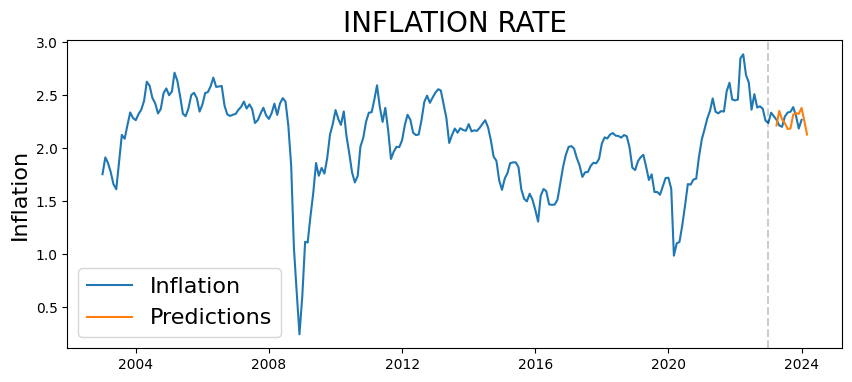

In [37]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.plot(prediction['pred_var'])
plt.legend(('Inflation', 'Predictions'), fontsize=16)
plt.title('INFLATION RATE', fontsize=20)
plt.ylabel('Inflation', fontsize=16)
for year in range(start_date.year,end_date.year):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [38]:
print('Mean Absolute Percent Error(%):', round(np.mean(abs(rolling_residuals/test_data['Inflation']))*100,4))

Mean Absolute Percent Error(%): 4.2973


In [39]:
print('Root Mean Squared Error(%):', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error(%): 0.10774329779611849


# Forecasting The Future

In [40]:
df.index.max()

Timestamp('2024-01-01 00:00:00')

In [41]:
#12 months future projection
future_index = pd.date_range(df.index.max() + relativedelta(months=1),df.index.max() + relativedelta(months=12), freq='MS')


In [42]:
future_index

DatetimeIndex(['2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [43]:
df_to_predict = pd.DataFrame(index=future_index,columns=df.columns)

In [44]:
#Concatenate Initial dataset and future dataset
df_all = pd.concat([df, df_to_predict], axis=0)
df_all.head()

,Inflation
2003-01-01,1.754286
2003-02-01,1.912632
2003-03-01,1.862857
2003-04-01,1.774762
2003-05-01,1.660952


In [45]:
df_all.tail()

,Inflation
2024-09-01,NaN
2024-10-01,NaN
2024-11-01,NaN
2024-12-01,NaN
2025-01-01,NaN


In [46]:
df_all.shape

(265, 1)

In [47]:
# Split train and test
train_data02 = df_all.iloc[:-24]
print('Train size: ', len(train_data02))
test_data02 = df_all.iloc[-24:]
print('Test size: ',len(test_data02))

Train size:  241
Test size:  24


# Rolling Forecast Origin

In [48]:
pred_list02 = []
for train_end in test_data02.index:
  train_data02 = df_all[:train_end-timedelta(days=1)]
  model02 = ARIMA(train_data02, order=my_order)
  # print('Train end',train_end)
  # print('Train',train_data02)
  model_fit = model02.fit()

  pred02 = model_fit.forecast()
  pred_list02.append(pred02.values)

prediction02 = pd.DataFrame(pred_list02)

In [49]:
col02 = ['pred_var']
prediction02.columns = col02
prediction02.set_index(test_data02.index,inplace=True)

In [50]:
prediction02

,pred_var
2023-02-01,2.213859
2023-03-01,2.350576
2023-04-01,2.270435
2023-05-01,2.236039
2023-06-01,2.180611
2023-07-01,2.184410
2023-08-01,2.316307
2023-09-01,2.329212
2023-10-01,2.322828
2023-11-01,2.378598


In [51]:
start_date = datetime(2023,2,1)
end_date = datetime(2024,4,1)

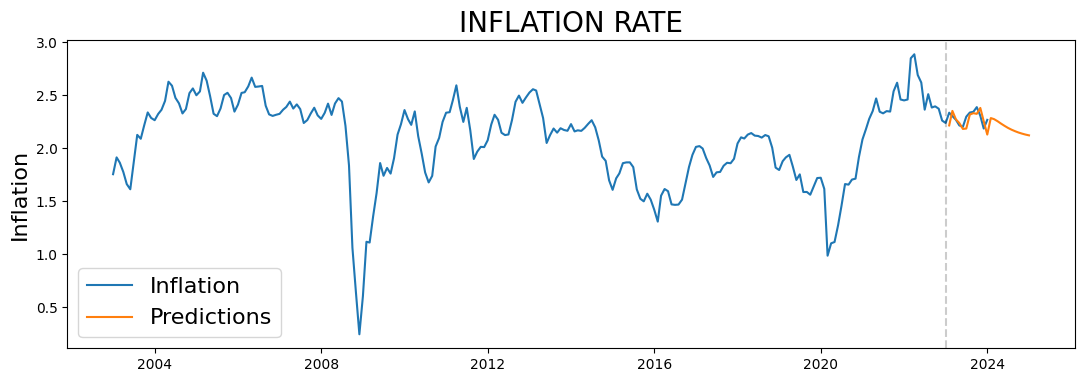

In [52]:
plt.figure(figsize=(13,4))

plt.plot(df_all)
plt.plot(prediction02['pred_var'])
plt.legend(('Inflation', 'Predictions'), fontsize=16)
plt.title('INFLATION RATE', fontsize=20)
plt.ylabel('Inflation', fontsize=16)
for year in range(start_date.year,end_date.year):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)